# Bibliotecas

In [2]:
import pandas as pd
import numpy as np
import psycopg2 as postgres
import psycopg2.extras
import csv
import random
from sshtunnel import SSHTunnelForwarder
from tqdm import tqdm
import ast

# Funções

In [3]:
def executeQuery(conn, sql):
    record = None
    try:
        #print(sql)
        cur = conn.cursor(cursor_factory = psycopg2.extras.RealDictCursor)
        cur.execute(sql)
        record = cur.fetchall()
        cur.close()
    except postgres.Error as e:
        print(e)
        cur.execute("ROLLBACK")
        cur.close()
    return record

In [4]:
#Recebe um id e retorna as categorias e checkin do lugar
def getPOIInformation(conn, business_id):
    
    sql = """
        SELECT id, checkin_count, name, level FROM pois_information WHERE id  = \'"""+str(business_id)+ """\'
    ;"""

    result = executeQuery(conn, sql)

    return result

In [5]:
def generate_path_corpus_all(bin_number, size):
    #Criar a janela ao redor do POI e unir as sentenças
    
    wnd = (bin_number+1)*size

    with SSHTunnelForwarder(
        ('150.165.15.171', 23456),
        #ssh_private_key="</path/to/private/ssh/key>",
        ### in my case, I used a password instead of a private key
        ssh_username="salatiel",
        ssh_password="Salatiel@Lacina123", 
        remote_bind_address=('localhost', 5432)) as server:

            server.start()
            #print("server connected")

            params = {'database': 'austin_test',
                   'user': 'salatiel',
                   'password': 'root',
                   'host': 'localhost',
                   'port': server.local_bind_port
            }

            connection = psycopg2.connect(**params)
            
            file_name = './geographic/SHORTEST PATH/austin-shortest_path-' + str(bin_number) + '-FT-c_gpu.csv'

            print("loading file:", file_name)
            all_pois_path = []
            with open(file_name, newline='') as f:
                csv_reader = csv.reader(f)
                for row in csv_reader:
                    all_pois_path.append(row)
            
            file_name_corpus = './geographic/SHORTEST PATH CORPUS/austin-shortest_path_corpus-' + str(bin_number) + '-FT-c_gpu.csv'
    
            csv_file = open(file_name_corpus, "w", newline='')
            writer = csv.writer(csv_file, delimiter=',')
            writer.writerow(["poi_id_center",
                         "center_poi",
                         "center_poi_level",
                         #"context_poi_id",
                         "context_poi",
                         "context_poi_level"])

            for poi_path in tqdm(all_pois_path):
            
                sub_path = list(range(0, wnd+1))
                sub_path_types = []

                #Preenchendo lista inicial
                for sb_idx in sub_path:

                    if (sb_idx < len(poi_path)):

                        poi_id = poi_path[sb_idx]
                        poi_information = getPOIInformation(connection, poi_id)

                        if (len(poi_information) > 0):

                            columns = list(dict(poi_information[0]).keys())
                            poi_information = pd.DataFrame(poi_information, columns=columns)
                            #poi_types = list(poi_information['name'])
                            sub_path_types.append(poi_information)

                #Iniciando o processo de associações
                for i in range(len(poi_path)):

                    #Associações binárias
                    #sub_path[0] é o POI alvo
                    target_types= sub_path_types[0]
                    for j in range(1, len(sub_path_types)):
                        neighbor_types = sub_path_types[j]

                        for id_t, tg in target_types.iterrows():
                            for id_n, ng in neighbor_types.iterrows():
                                
                                if (tg['name'] !=  ng['name']):
                                
                                    #print(tg['id'], tg['name'], tg['level'], ng['id'], ng['name'], ng['level'])

                                    line = [str(tg['id']), 
                                            str(tg['name']),
                                            str(tg['level']), 
                                            #str(ng['id']),
                                            str(ng['name']),
                                            str(ng['level'])]

                                    writer.writerow(line)


                    #break
                    
                    new_poi = i+(wnd)+1
                    sub_path.pop(0)
                    sub_path.append(new_poi)
                    sub_path_types.pop(0)

                    if (new_poi < len(poi_path)):

                        poi_id = poi_path[new_poi]
                        poi_information = getPOIInformation(connection, poi_id)

                        if (len(poi_information) > 0):

                            columns = list(dict(poi_information[0]).keys())
                            poi_information = pd.DataFrame(poi_information, columns=columns)
                            sub_path_types.append(poi_information)

            connection.close()
            csv_file.close()
            
    return None    

In [8]:
def generate_path_corpus_zoning_all(all_pois_path, size):
    #Criar a janela ao redor do POI e unir as sentenças
    
    wnd = size
    
    #print('processing wnd', size)

    with SSHTunnelForwarder(
        ('150.165.15.171', 23456),
        #ssh_private_key="</path/to/private/ssh/key>",
        ### in my case, I used a password instead of a private key
        ssh_username="salatiel",
        ssh_password="Salatiel@Lacina123", 
        remote_bind_address=('localhost', 5432)) as server:

            server.start()
            #print("server connected")

            params = {'database': 'atlanta',
                   'user': 'salatiel',
                   'password': 'root',
                   'host': 'localhost',
                   'port': server.local_bind_port
            }

            connection = psycopg2.connect(**params)
            
#             file_name = './geographic/SHORTEST PATH/austin-shortest_path-zoning-FT_gpu.csv'

#             print("loading file:", file_name)
#             all_pois_path = []
#             with open(file_name, newline='') as f:
#                 csv_reader = csv.reader(f)
#                 for row in csv_reader:
#                     all_pois_path.append(row)
            
            file_name_corpus = './Atlanta/Shortest Path/atlanta-neighborhood-shortest_path_corpus-zoning-k' + str(wnd) + '-FT_gpu.csv'
            #file_name_corpus = './Boston/Shortest Path/boston-neighborhood-shortest_path_corpus-zoning-k' + str(wnd) + '-FT_gpu.csv'
    
            csv_file = open(file_name_corpus, "w", newline='')
            writer = csv.writer(csv_file, delimiter=',')
            writer.writerow(["poi_id_center",
                         "center_poi",
                         "center_poi_level",
                         #"context_poi_id",
                         "context_poi",
                         "context_poi_level"])

            for index, poi_path in enumerate(tqdm(all_pois_path)):
            #for p, poi_path in enumerate(all_pois_path):
                
                #print('path', p)
            
                sub_path = list(range(0, wnd+1))
                sub_path_types = []

                #Preenchendo lista inicial
                for sb_idx in sub_path:

                    if (sb_idx < len(poi_path)):

                        poi_id = poi_path[sb_idx]
                        poi_information = getPOIInformation(connection, poi_id)

                        if (len(poi_information) > 0):

                            columns = list(dict(poi_information[0]).keys())
                            poi_information = pd.DataFrame(poi_information, columns=columns)
                            #poi_types = list(poi_information['name'])
                            sub_path_types.append(poi_information)

                #Iniciando o processo de associações
                for i in range(len(poi_path)):
                #for i in tqdm(range(len(poi_path))):

                    #Associações binárias
                    #sub_path[0] é o POI alvo
                    if(len(sub_path_types) > 0):
                        target_types= sub_path_types[0]
                        for j in range(1, len(sub_path_types)):
                            neighbor_types = sub_path_types[j]

                            for id_t, tg in target_types.iterrows():
                                for id_n, ng in neighbor_types.iterrows():

                                    if (tg['name'] !=  ng['name']):

                                        #print(tg['id'], tg['name'], tg['level'], ng['id'], ng['name'], ng['level'])

                                        line = [str(tg['id']), 
                                                str(tg['name']),
                                                str(tg['level']), 
                                                #str(ng['id']),
                                                str(ng['name']),
                                                str(ng['level'])]

                                        writer.writerow(line)

                        new_poi = i+(wnd)+1
                        sub_path.pop(0)
                        sub_path.append(new_poi)
                        sub_path_types.pop(0)

                        if (new_poi < len(poi_path)):

                            poi_id = poi_path[new_poi]
                            poi_information = getPOIInformation(connection, poi_id)

                            if (len(poi_information) > 0):

                                columns = list(dict(poi_information[0]).keys())
                                poi_information = pd.DataFrame(poi_information, columns=columns)
                                sub_path_types.append(poi_information)
                    
#                     except Exception as e:
#                         logger.error('Failed to upload to ftp: %s', repr(e))
#                         print('path:', index) 
#                         print('poi_idx_in_path:', i) 
#                         print('poi_id:', poi_id)
#                         print('sub_path:', sub_path)
#                         print('sb_idx:', sb_idx)
#                         print('len poi_path:', len(poi_path))
#                         print('len sub_path_types:', sub_path_types)
                        
#                         break

            connection.close()
            csv_file.close()
            
    return None

In [ ]:
generate_path_corpus_zoning_all(10)

processing wnd 10


  0%|          | 0/105 [00:00<?, ?it/s]

loading file: ./geographic/SHORTEST PATH/austin-shortest_path-zoning-FT_gpu.csv


  2%|▏         | 2/105 [01:00<32:27, 18.91s/it]

# Leitura de Dados

In [27]:
bin_number = 0
#file_name = './geographic/SHORTEST PATH/austin-shortest_path-' + str(bin_number) + '-CF-c.csv'
#file_name = './geographic/SHORTEST PATH/austin-shortest_path-' + str(bin_number) + '-FT-c_gpu.csv'
#file_name = './geographic/SHORTEST PATH/austin-shortest_path-zoning-FT_gpu.csv'
#file_name = './Atlanta/Shortest Path/atlanta-shortest_path-zoning-FT_gpu.csv'
#file_name = './Boston/Shortest Path/boston-shortest_path-zoning-FT_gpu.csv'
#file_name = './Boston/Shortest Path/boston-neighborhood-shortest_path-zoning-FT_gpu.csv'
file_name = './Atlanta/Shortest Path/atlanta-neighborhood-shortest_path-zoning-FT_gpu.csv'


print("loading file:", file_name)
all_pois_path = []
with open(file_name, newline='') as f:
    csv_reader = csv.reader(f)
    for row in csv_reader:
        if len(row) > 1:
            all_pois_path.append(row)
        
print(len(all_pois_path))

loading file: ./Atlanta/Shortest Path/atlanta-neighborhood-shortest_path-zoning-FT_gpu.csv
3499


In [28]:
#REMOVENDO DUPLICADAS
import itertools
all_pois_path = list(k for k,_ in itertools.groupby(all_pois_path))

In [29]:
len(all_pois_path)

1347

In [30]:
avg = 0
max_path = -np.inf
min_path = np.inf
path_sizes = []
counter_90 = 0
for path in all_pois_path:
    path_sizes.append(len(path))
    if(len(path) >= 90):
        counter_90 += 1
    if (len(path) > max_path):
        max_path = len(path)
    elif(len(path) < min_path):
        min_path = len(path)
    avg += len(path)

print('comprimento máximo:', max_path)
print('comprimento mínimo:', min_path)
print('média de comprimento:', avg/len(all_pois_path))
print('mediana do comprimento:', np.median(path_sizes))
print('quantidade de caminhos acima de 90:', counter_90, 'de', len(all_pois_path))

comprimento máximo: 841
comprimento mínimo: 2
média de comprimento: 49.922048997772826
mediana do comprimento: 15.0
quantidade de caminhos acima de 90: 124 de 1347


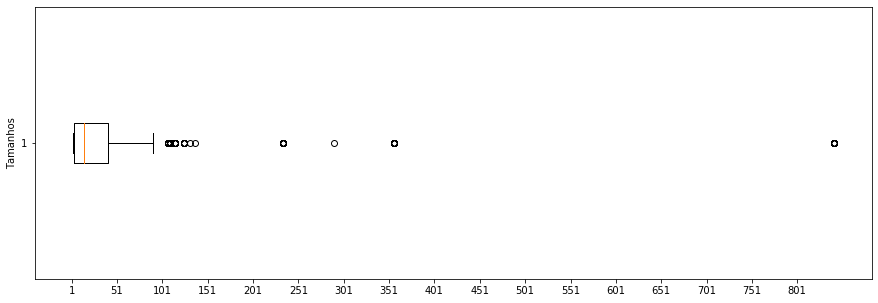

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

# Ajustar o tamanho da figura (aumentar o comprimento)
plt.figure(figsize=(15, 5))  # Largura 10, altura 5

# Criar o boxplot na horizontal
plt.boxplot(path_sizes, vert=False)
plt.ylabel("Tamanhos")

min_val, max_val = min(path_sizes), max(path_sizes)
plt.xticks(np.arange(min_val - 1, max_val + 2, 50))  # Ticks de 1 em 1


# Exibir o gráfico
plt.show()

# Geração das Sentenças

In [11]:
#Escolhe aleatoreamente um tipo para compor a sentença
for rnd in range(0, 12):

    with SSHTunnelForwarder(
    ('150.165.15.171', 23456),
    #ssh_private_key="</path/to/private/ssh/key>",
    ### in my case, I used a password instead of a private key
    ssh_username="salatiel",
    ssh_password="Salatiel@Lacina123", 
    remote_bind_address=('localhost', 5432)) as server:

        server.start()
        #print("server connected")

        params = {'database': 'austin_test',
               'user': 'salatiel',
               'password': 'root',
               'host': 'localhost',
               'port': server.local_bind_port
        }

        connection = psycopg2.connect(**params)

        all_sentences = []

        for poi_path in tqdm(all_pois_path):
        #for poi_path in all_pois_path:
            poi_path_sentence = [] 
            for poi_id in poi_path: 
                #Obtendo informações de categorias e checkin do poi central
                #[business_id, checkin, category]
                poi_information = getPOIInformation(connection, poi_id)

                if (len(poi_information) > 0):

                    columns = list(dict(poi_information[0]).keys())
                    poi_information = pd.DataFrame(poi_information, columns = columns)

                    type_by_level = []

                    for level in range(5):

                        level_poi_information = poi_information[poi_information['level'] == level]
                        poi_types = list(level_poi_information['name'])
                        if (len(poi_types) > 0):
                            poi_type = poi_types[random.randint(0, len(poi_types)-1)]
                            type_by_level.append(poi_type)

                    #Selecionar aleatoreamente entre todos os tipos
                    selected_type = type_by_level[random.randint(0, len(type_by_level)-1)]
                    #print(type_by_level, selected_type)
                    poi_path_sentence.append(selected_type)


            all_sentences.append(poi_path_sentence)
            
    #file_name = './geographic/SHORTEST PATH/austin-shortest_path_corpus-' + str(bin_number) + '-rnd'+str(rnd)+'-CF-c.csv'
    file_name = './geographic/SHORTEST PATH/austin-shortest_path_corpus-' + str(bin_number) + '-rnd'+str(rnd)+'-FT-c.csv'

    csv_file_02 = open(file_name, "w", newline='')
    writer_path = csv.writer(csv_file_02, delimiter=',')
    for st in all_sentences:
        writer_path.writerow(st)

 65%|██████▍   | 14473/22399 [13:19<08:16, 15.97it/s] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 72%|███████▏  | 16060/22399 [14:46<08:43, 12.10it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



# Execução em Paralelo

In [7]:
#Quantidade de tuplas de vizinhos nos dados do yelp (center, context) considerando d = 100m
pois_file_name = './austin-ml-updated.csv'
poi_df = pd.read_csv(pois_file_name)
print(poi_df.shape)
poi_df = poi_df.dropna()
print(poi_df.shape)
poi_df.head()

(22399, 7)
(22399, 7)


,business_id,city,state,latitude,longitude,categories,checkin_count
0,N3_Gs3DnX4k9SgpwJxdEfw,Austin,TX,30.346169,-97.711458,"Shopping, Jewelry Repair, Appraisal Services, ...",14
1,tXvdYGvlEceDljN8gt2_3Q,Austin,TX,30.172706,-97.799920,"Barbers, Beauty & Spas",1
2,nTIhpR7MhsALPwg_Hh14EA,Austin,TX,30.326377,-97.704543,"Hotels, Hotels & Travel, Event Planning & Serv...",475
3,8XyEpVdAO0o6iVkVxkWosQ,Austin,TX,30.246465,-97.778738,"Home Services, Real Estate, Property Management",0
4,NVfOn7TdnHbaGH97CVB_Qg,Austin,TX,30.244902,-97.857409,"Chiropractors, Health & Medical",33


In [33]:
import multiprocessing as mp
print("Number of processors: ", mp.cpu_count())

# Step 1: Init multiprocessing.Pool()
pool = mp.Pool(int(mp.cpu_count()))


# Step 2: `pool.apply` the `howmany_within_range()`

# bins = [6, 7, 8]
# size = 10

#pool.starmap(generate_path_corpus_tg_cf, [(poi_df, n, size) for n in bins])

#size = [10, 20, 30, 40, 50]
size = [60, 70, 80, 90]


pool.starmap(generate_path_corpus_zoning_all, [(all_pois_path, sz) for sz in size])


# Step 3: Don't forget to close
pool.close()

#Para point
#calculateBinOSMPoints_Disco(df, n)

Number of processors:  20


100%|██████████| 1347/1347 [57:47<00:00,  2.57s/it]


In [42]:
all_pois_path[7][574]

'9_BYb_jBVb92bhQnRmCOjQ'